<a href="https://colab.research.google.com/github/AkshNaidu/single_cell_analysis/blob/main/single_cell_one_ipnyb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Install Seurat (only run once)
install.packages('Seurat')
install.packages('dplyr')
install.packages('ggplot2')
install.packages('patchwork')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘dotCall64’, ‘gtools’, ‘caTools’, ‘plyr’, ‘tensor’, ‘BH’, ‘sitmo’, ‘sp’, ‘spam’, ‘globals’, ‘listenv’, ‘parallelly’, ‘zoo’, ‘lazyeval’, ‘crosstalk’, ‘RcppTOML’, ‘here’, ‘gplots’, ‘reshape2’, ‘gridExtra’, ‘RcppArmadillo’, ‘spatstat.data’, ‘spatstat.univar’, ‘spatstat.random’, ‘spatstat.utils’, ‘spatstat.sparse’, ‘goftest’, ‘abind’, ‘deldir’, ‘polyclip’, ‘FNN’, ‘dqrng’, ‘SeuratObject’, ‘cowplot’, ‘fastDummies’, ‘fitdistrplus’, ‘future’, ‘future.apply’, ‘ggrepel’, ‘ggridges’, ‘ica’, ‘igraph’, ‘irlba’, ‘lmtest’, ‘matrixStats’, ‘patchwork’, ‘pbapply’, ‘plotly’, ‘png’, ‘progressr’, ‘RANN’, ‘RcppAnnoy’, ‘RcppHNSW’, ‘reticulate’, ‘ROCR’, ‘RSpectra’, ‘Rtsne’, ‘scattermore’, ‘sctransform’, ‘spatstat.explore’, ‘spatstat.geom’, ‘uwot’, ‘RcppEigen’, ‘RcppProgress’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/u

In [4]:
# Load libraries
library(Seurat)
library(dplyr)
library(ggplot2)
library(patchwork)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [6]:
# Create directories
dir.create("data", showWarnings = FALSE)

In [7]:
# Download the dataset (takes ~1 minute)
download.file(
  url = "https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz",
  destfile = "data/pbmc3k_data.tar.gz"
)

In [8]:
# Load the raw data (10X format)
untar("data/pbmc3k_data.tar.gz", exdir = "data/")

In [9]:
# Check if it worked
list.files("data/filtered_gene_bc_matrices/hg19/")

[1] "barcodes.tsv" "genes.tsv"    "matrix.mtx"

In [10]:
# Load the data (note the updated path!)
pbmc.data <- Read10X(data.dir = "data/filtered_gene_bc_matrices/hg19/")

In [11]:
# Check what you loaded
dim(pbmc.data)

[1] 32738  2700

In [12]:
# Create Seurat object
pbmc <- CreateSeuratObject(counts = pbmc.data,
                           project = "pbmc3k",
                           min.cells = 3,
                           min.features = 200)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [13]:
pbmc

An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)
 1 layer present: counts

In [14]:
# Calculate % of mitochondrial genes (dying cells have high %)
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

# Calculate % of ribosomal genes
pbmc[["percent.ribo"]] <- PercentageFeatureSet(pbmc, pattern = "^RP[SL]")



In [15]:
head(pbmc@meta.data)


,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.ribo
,<fct>,<dbl>,<int>,<dbl>,<dbl>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759,43.69574
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958,42.40261
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363,31.68097
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845,24.25161
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898,14.89796
AAACGCACTGGTAC-1,pbmc3k,2163,781,1.6643551,36.19972


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


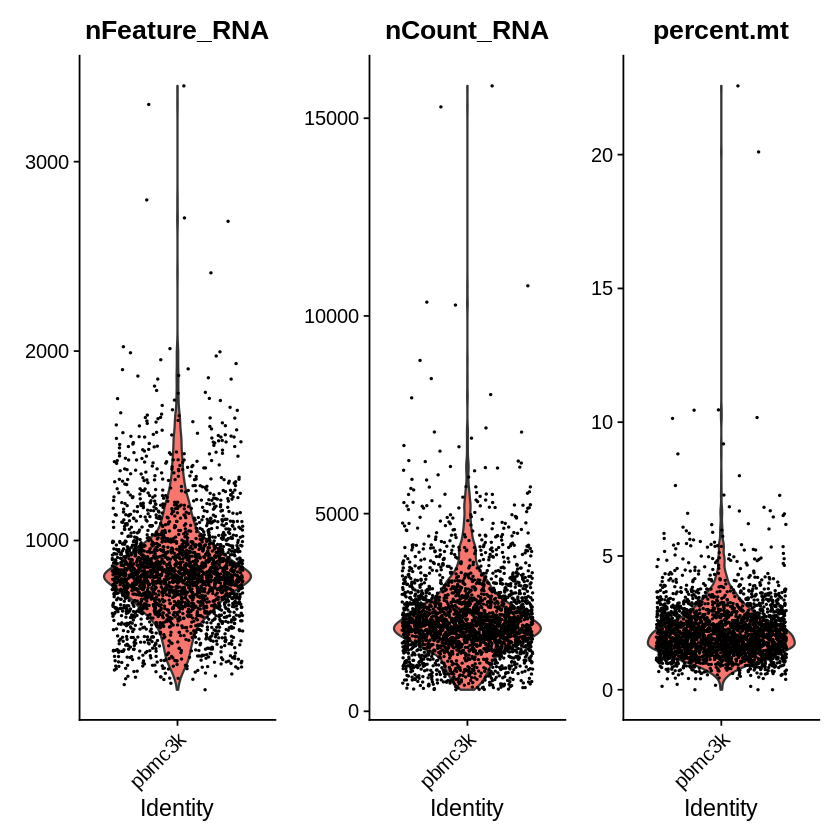

In [16]:
# Visualize QC metrics BEFORE filtering
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

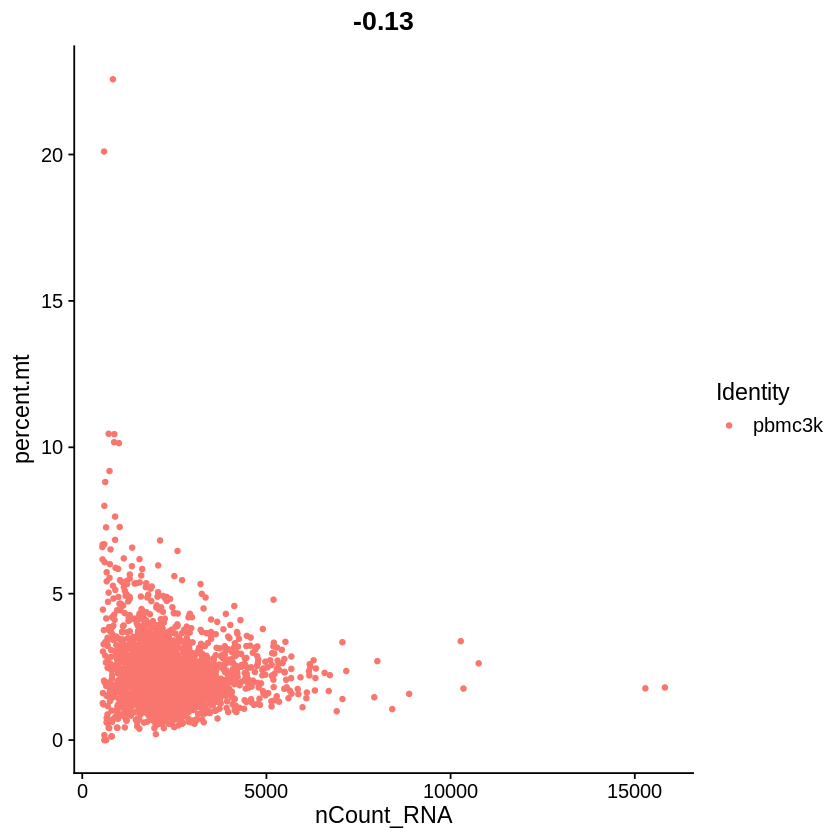

In [17]:
# Scatter plots to see relationships
FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")

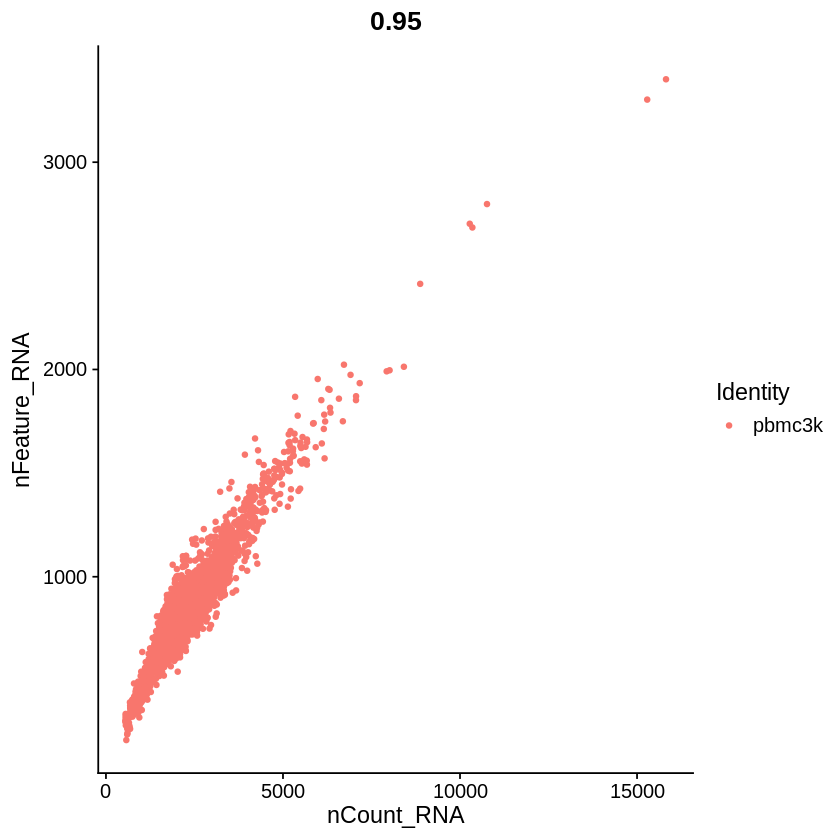

In [18]:
FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

In [19]:
# Filter: keep cells with 200-2500 genes and <5% mitochondrial content
pbmc <- subset(pbmc,
               subset = nFeature_RNA > 200 &
                        nFeature_RNA < 2500 &
                        percent.mt < 5)

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


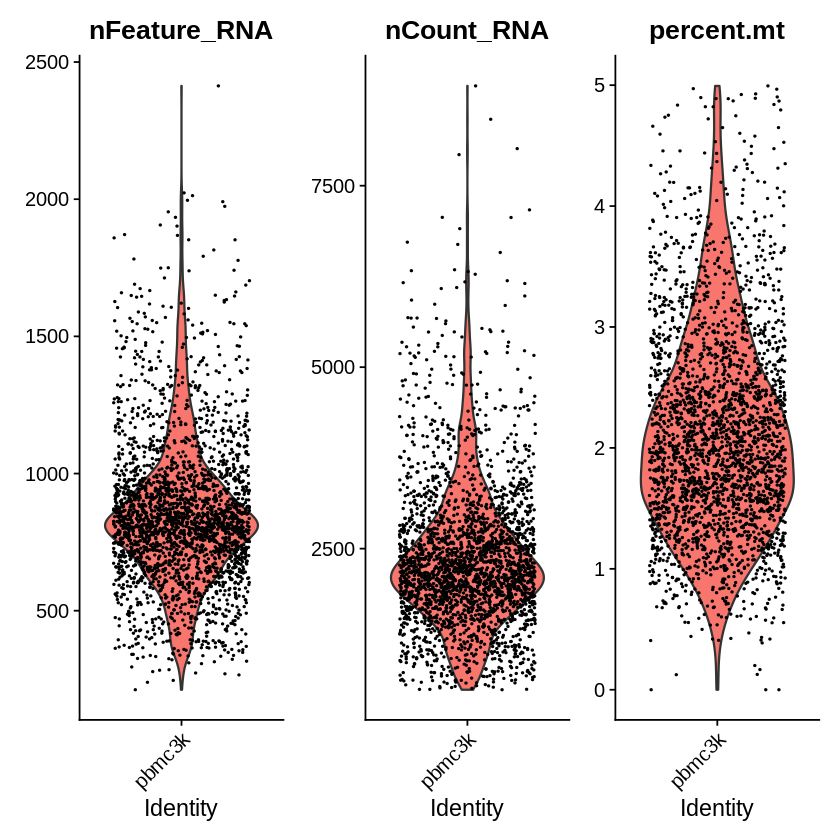

In [20]:
# Visualize QC metrics AFTER filtering
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [21]:
# Log-normalize: makes expression values comparable across cells
pbmc <- NormalizeData(pbmc,
                      normalization.method = "LogNormalize",
                      scale.factor = 10000)

Normalizing layer: counts



In [22]:
# Find the 2000 most variable genes (most informative)
pbmc <- FindVariableFeatures(pbmc,
                              selection.method = "vst",
                              nfeatures = 2000)

Finding variable features for layer counts



In [23]:
# See the top 10 most variable genes
top10 <- head(VariableFeatures(pbmc), 10)
top10

[1] "PPBP"   "LYZ"    "S100A9" "IGLL5"  "GNLY"   "FTL"    "PF4"    "FTH1"  
 [9] "GNG11"  "S100A8"

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


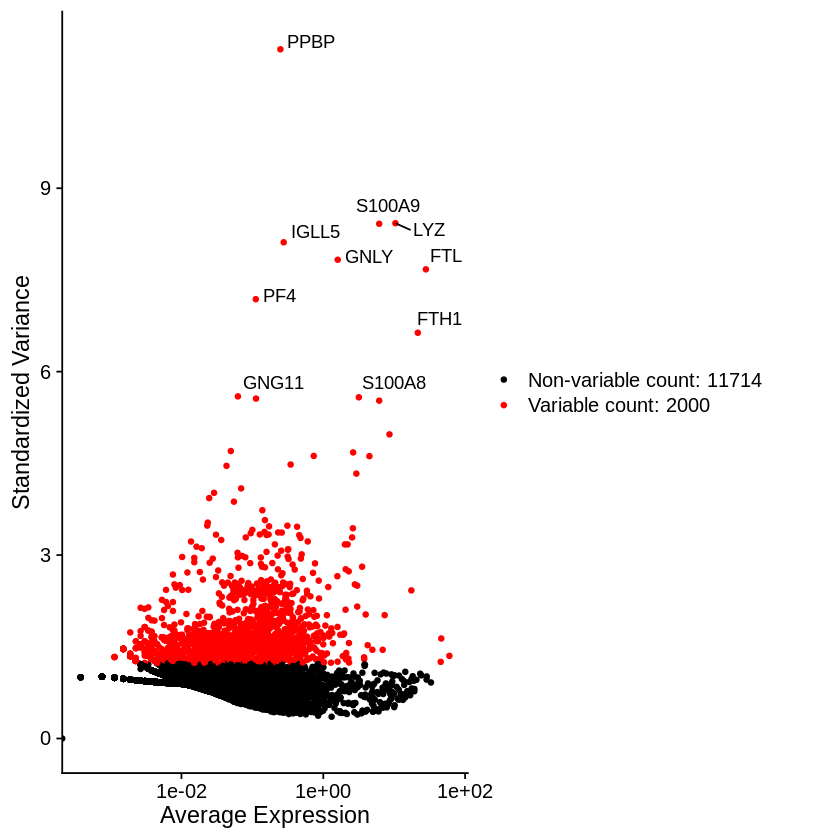

In [24]:
# Plot variable features
plot1 <- VariableFeaturePlot(pbmc)
LabelPoints(plot = plot1, points = top10, repel = TRUE)

In [25]:
# Get all gene names
all.genes <- rownames(pbmc)

In [26]:
# Scale data: mean=0, variance=1 for each gene
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



In [27]:
# Run PCA using variable genes
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1, HLA-DPA

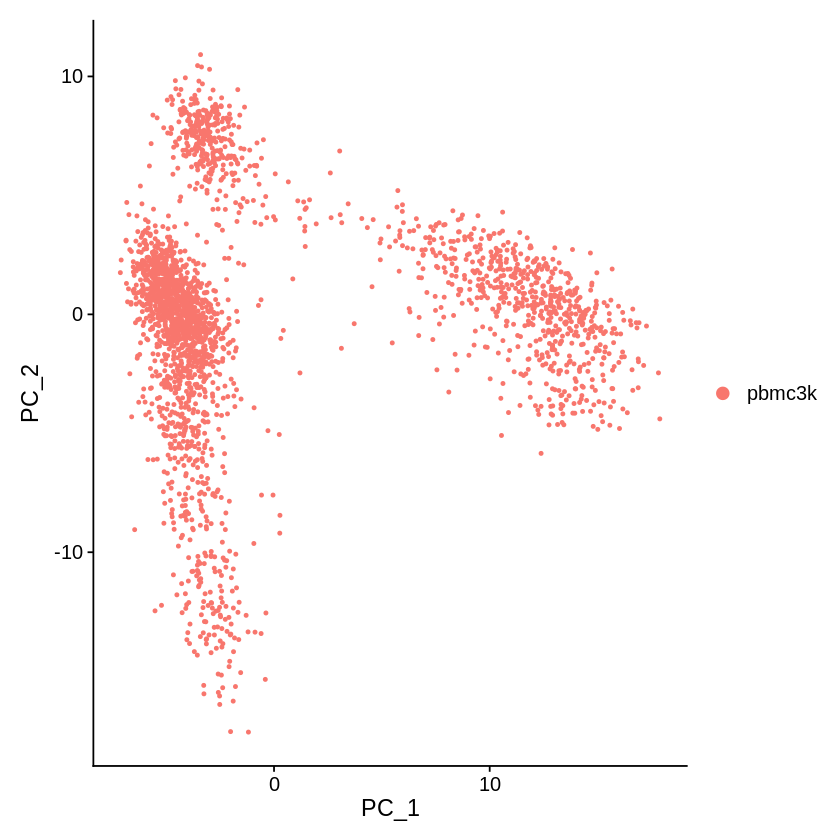

In [28]:
# Visualize PCA
DimPlot(pbmc, reduction = "pca")

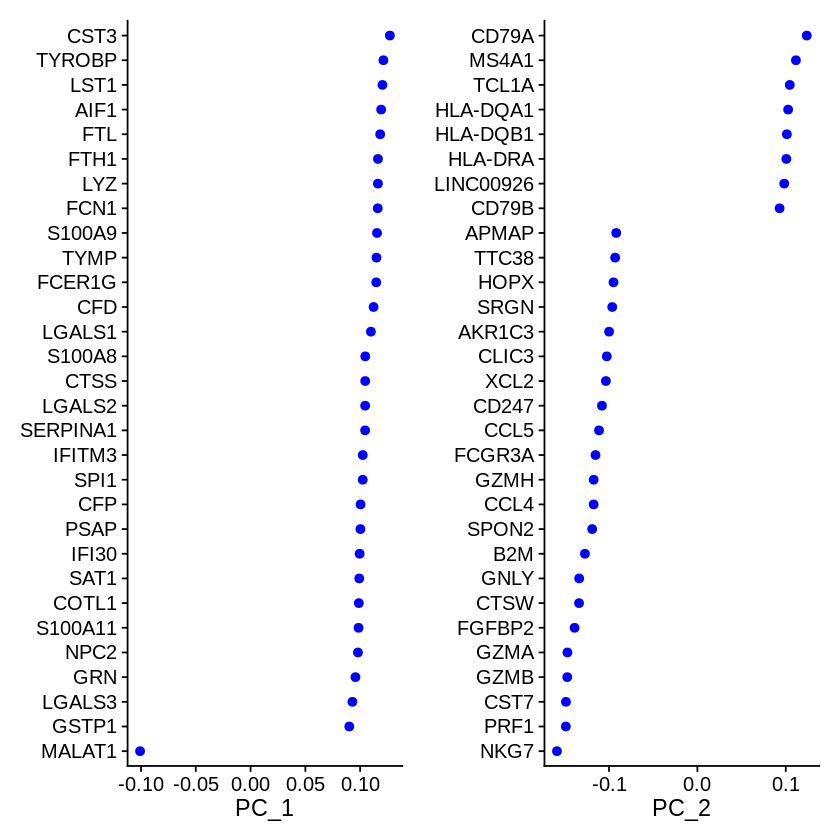

In [29]:
# See which genes contribute to PC1 and PC2
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

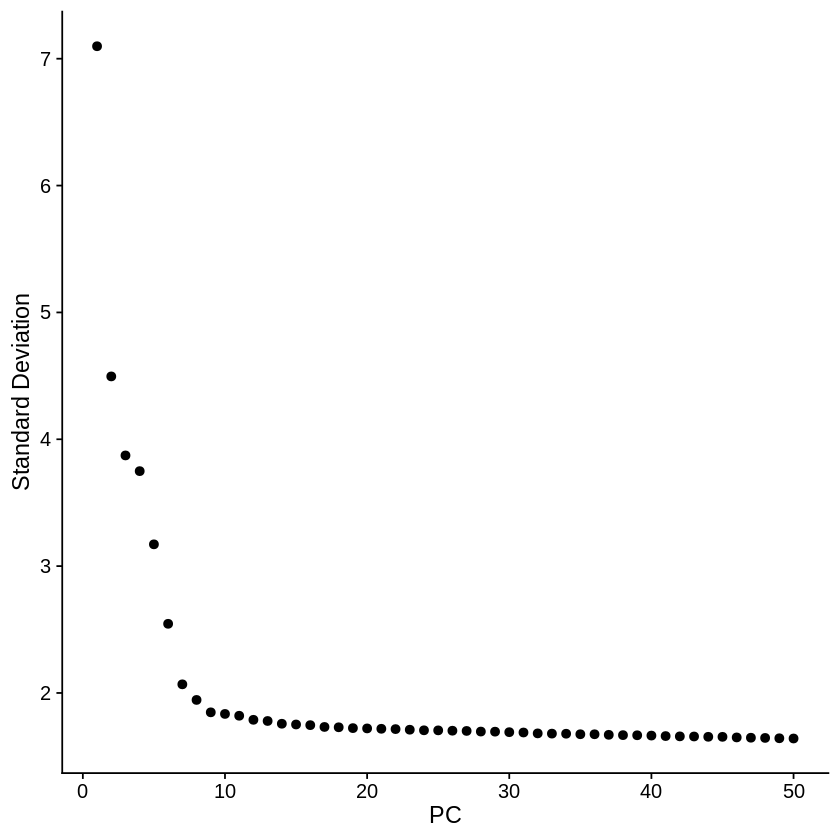

In [30]:
# Elbow plot: helps decide how many PCs to use
ElbowPlot(pbmc, ndims = 50)

In [31]:
# Build nearest neighbor graph (using first 10 PCs)
pbmc <- FindNeighbors(pbmc, dims = 1:10)

Computing nearest neighbor graph

Computing SNN



In [32]:
# Find clusters (resolution = granularity)
pbmc <- FindClusters(pbmc, resolution = 0.5)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95965

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8723
Number of communities: 9
Elapsed time: 0 seconds


In [33]:
# See how many cells in each cluster
table(Idents(pbmc))


  0   1   2   3   4   5   6   7   8 
711 480 472 344 279 162 144  32  14 

In [34]:
# Run UMAP for 2D visualization
pbmc <- RunUMAP(pbmc, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
20:59:48 UMAP embedding parameters a = 0.9922 b = 1.112

20:59:48 Read 2638 rows and found 10 numeric columns

20:59:48 Using Annoy for neighbor search, n_neighbors = 30

20:59:48 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:59:48 Writing NN index file to temp file /tmp/RtmpJTKMR7/file31e12b51f2a

20:59:48 Searching Annoy index using 1 thread, search_k = 3000

20:59:49 Annoy recall = 100%

20:59:49 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 

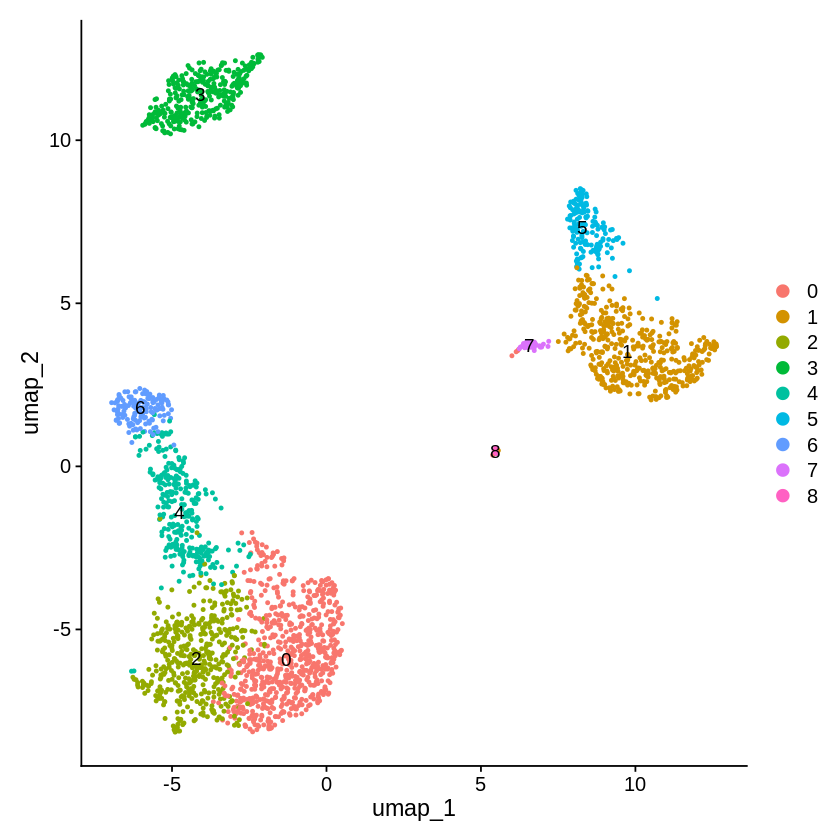

In [35]:
# Plot UMAP with cluster labels
DimPlot(pbmc, reduction = "umap", label = TRUE)

In [36]:
# Find markers for all clusters
pbmc.markers <- FindAllMarkers(pbmc,
                                only.pos = TRUE,
                                min.pct = 0.25,
                                logfc.threshold = 0.25)

Calculating cluster 0

For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



In [37]:
# Look at the results
head(pbmc.markers)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
RPS12,1.806317e-144,0.7439459,1.000,0.991,2.477183e-140,0,RPS12
RPS6,7.135900e-142,0.6862148,1.000,0.995,9.786173e-138,0,RPS6
RPS27,5.257820e-140,0.7298479,0.999,0.992,7.210575e-136,0,RPS27
RPL32,4.229582e-136,0.6184804,0.999,0.995,5.800448e-132,0,RPL32
RPS14,1.799019e-130,0.6283021,1.000,0.994,2.467175e-126,0,RPS14
RPS25,5.507298e-123,0.7635765,0.997,0.975,7.552709e-119,0,RPS25


In [38]:
# Get top 10 markers per cluster
top10_markers <- pbmc.markers %>%
  group_by(cluster) %>%
  top_n(n = 10, wt = avg_log2FC)

In [39]:
# View markers for cluster 0
pbmc.markers %>% filter(cluster == 0) %>% head()

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
RPS12,1.806317e-144,0.7439459,1.000,0.991,2.477183e-140,0,RPS12
RPS6,7.135900e-142,0.6862148,1.000,0.995,9.786173e-138,0,RPS6
RPS27,5.257820e-140,0.7298479,0.999,0.992,7.210575e-136,0,RPS27
RPL32,4.229582e-136,0.6184804,0.999,0.995,5.800448e-132,0,RPL32
RPS14,1.799019e-130,0.6283021,1.000,0.994,2.467175e-126,0,RPS14
RPS25,5.507298e-123,0.7635765,0.997,0.975,7.552709e-119,0,RPS25


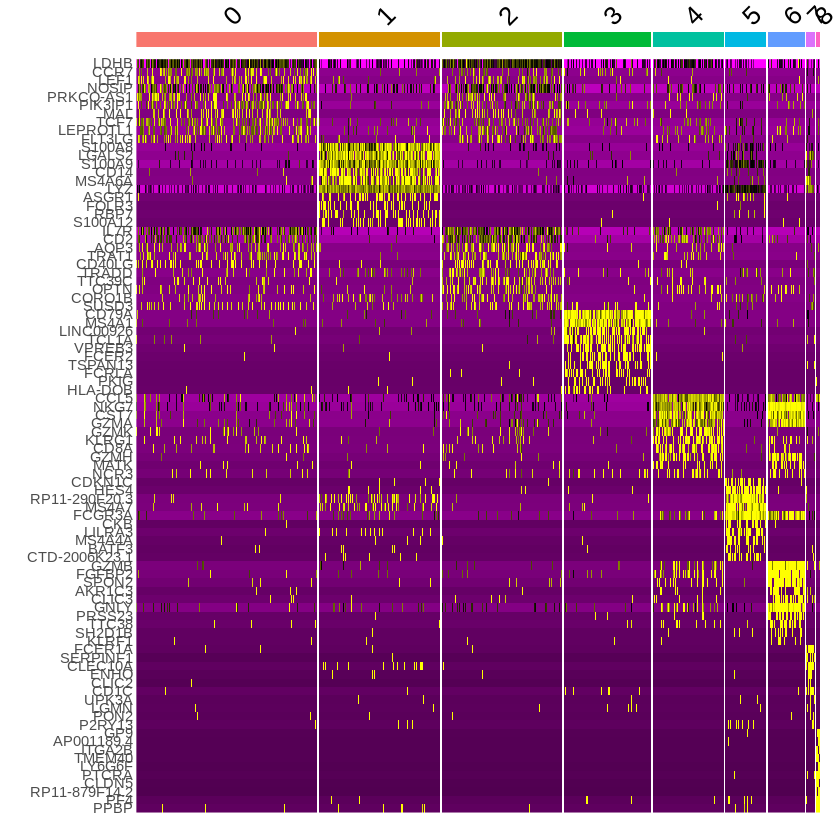

In [40]:
# Heatmap of top markers
DoHeatmap(pbmc, features = top10_markers$gene) + NoLegend()

In [41]:
# Assign cell type names based on markers
new.cluster.ids <- c("Naive CD4 T", "CD14+ Mono", "Memory CD4 T",
                     "B", "CD8 T", "FCGR3A+ Mono",
                     "NK", "DC", "Platelet")

In [42]:
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)

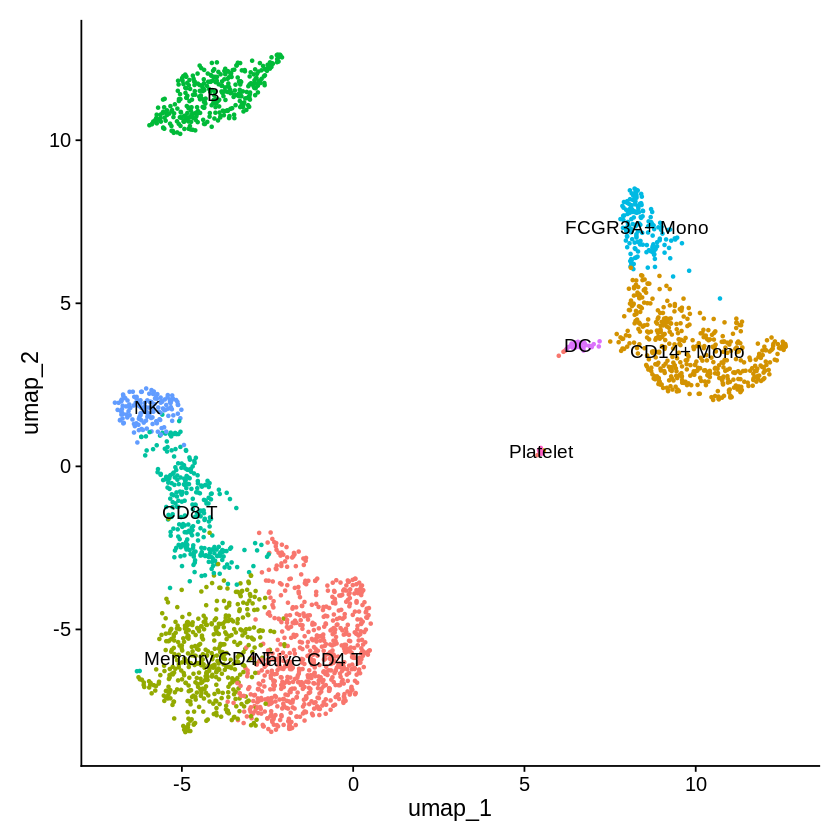

In [43]:
# Plot UMAP with cell type labels
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

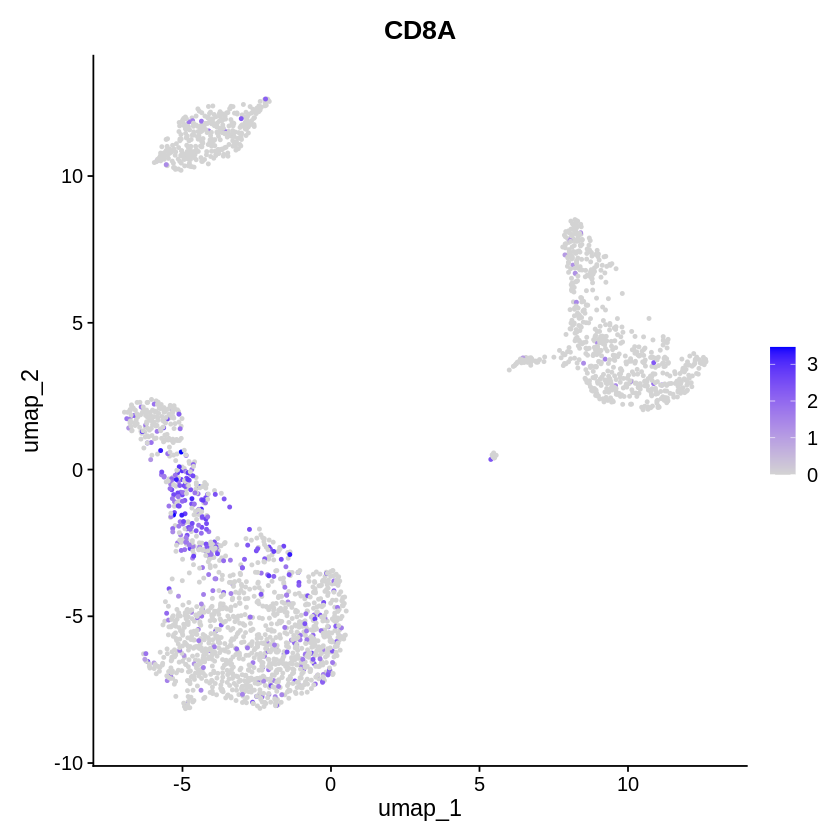

In [44]:
FeaturePlot(pbmc, features = c("CD8A"))  # CD8 T cell marker

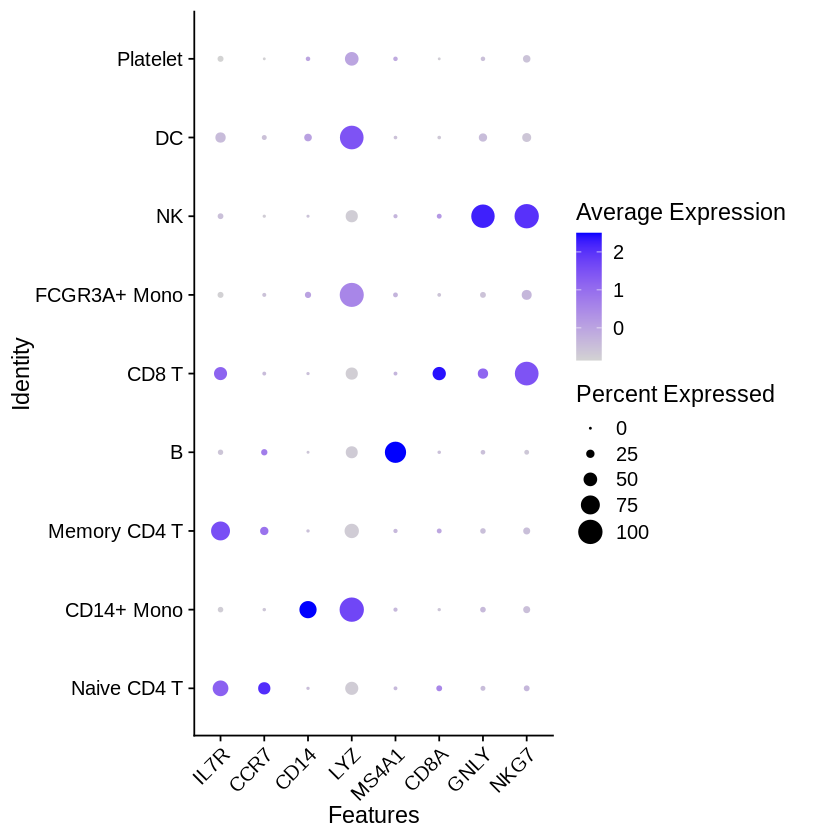

In [45]:
# Dot plot of canonical markers
DotPlot(pbmc, features = c("IL7R", "CCR7", "CD14", "LYZ",
                            "MS4A1", "CD8A", "GNLY", "NKG7")) +
  RotatedAxis()

In [46]:
# Compare two cell types
mono_de <- FindMarkers(pbmc,
                       ident.1 = "CD14+ Mono",
                       ident.2 = "FCGR3A+ Mono")

In [47]:
# Look at top results
head(mono_de)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCGR3A,1.193617e-101,-5.019527,0.131,0.975,1.636926e-97
LYZ,8.134552e-75,2.654926,1.000,0.988,1.115572e-70
RHOC,4.479768e-68,-3.319102,0.162,0.864,6.143554e-64
S100A8,7.471811e-65,4.017063,0.975,0.500,1.024684e-60
S100A9,1.318422e-64,3.395934,0.996,0.870,1.808084e-60
IFITM2,4.821669e-64,-2.227960,0.677,1.000,6.612437e-60


In [48]:
# Count cells per type
table(Idents(pbmc))


 Naive CD4 T   CD14+ Mono Memory CD4 T            B        CD8 T FCGR3A+ Mono 
         711          480          472          344          279          162 
          NK           DC     Platelet 
         144           32           14 

In [49]:
# Calculate percentages
prop.table(table(Idents(pbmc))) * 100


 Naive CD4 T   CD14+ Mono Memory CD4 T            B        CD8 T FCGR3A+ Mono 
  26.9522365   18.1956027   17.8923427   13.0401820   10.5761941    6.1410159 
          NK           DC     Platelet 
   5.4586808    1.2130402    0.5307051 

In [50]:
# Save the Seurat object
saveRDS(pbmc, file = "pbmc_analyzed.rds")

In [51]:
# Load it back later
pbmc <- readRDS("pbmc_analyzed.rds")

In [ ]:
# Install Monocle3 and dependencies
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install(c("monocle3", "slingshot", "SingleCellExperiment"))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.22 (BiocManager 1.30.27), R 4.5.2 (2025-10-31)

Installing package(s) 'BiocVersion', 'monocle3', 'slingshot',
  'SingleCellExperiment'

Warning message:
“package ‘monocle3’ is not available for Bioconductor version '3.22'

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
also installing the dependencies ‘XVector’, ‘MatrixGenerics’, ‘Biobase’, ‘IRanges’, ‘Seqinfo’, ‘S4Arrays’, ‘SparseArray’, ‘princurve’, ‘TrajectoryUtils’, ‘S4Vectors’, ‘SummarizedExperiment’, ‘BiocGenerics’, ‘GenomicRanges’, ‘DelayedArray’


